# A. Import Library & Connect to Database

In [157]:
import pandas as pd
import numpy as np
import pyodbc
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [123]:
#Connect to SQL Server database
conn = pyodbc.connect( 
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost\SQLEXPRESS;"
    "DATABASE=vti_data;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;")

df = pd.read_sql_query('''
                                        
SELECT *
FROM [vti_data].[dbo].[1.online_retail_dataset]
                                       
    ; ''', conn)
df

<>:4: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
<>:4: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
C:\Users\Hiep\AppData\Local\Temp\ipykernel_12184\1118688564.py:4: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
  "SERVER=localhost\SQLEXPRESS;"
C:\Users\Hiep\AppData\Local\Temp\ipykernel_12184\1118688564.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('''


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,695.0,130850.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,675.0,130850.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,675.0,130850.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,21.0,130850.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,125.0,130850.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,21.0,126800.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,415.0,126800.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,415.0,126800.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,495.0,126800.0,France


# B. Data Overview

In [124]:
df.shape

(1067371, 8)

The dataset contains 1,067,371 rows and 8 columns.

In [125]:
df.describe()

,Quantity,InvoiceDate,Price,Customer_ID
count,1.067371e+06,1067371,1.067366e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.214907e+02,153246.385044
min,-8.099500e+04,2009-12-01 07:45:00,0.000000e+00,123460.000000
25%,1.000000e+00,2010-07-09 09:46:00,8.500000e+01,139750.000000
50%,3.000000e+00,2010-12-07 15:28:00,1.950000e+02,152550.000000
75%,1.000000e+01,2011-07-22 10:23:00,3.950000e+02,167970.000000
max,8.099500e+04,2011-12-09 12:50:00,2.511109e+06,182870.000000
std,1.727058e+02,NaN,7.781753e+03,16974.644504


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067366 non-null  float64       
 6   Customer_ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [127]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer_ID           float64
Country                object
dtype: object

# C. Data Cleaning & Preprocessing

## 1. Remove Duplicate Rows

In [128]:
df.duplicated().sum()

np.int64(34335)

In [129]:
df = df.drop_duplicates()
df.shape

(1033036, 8)

## 2. Handle Missing Value

In [130]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4275
Quantity            0
InvoiceDate         0
Price               5
Customer_ID    235151
Country             0
dtype: int64

In [131]:
# Rows with missing Customer_ID were removed since customer-level analysis (RFM, segmentation) cannot be performed on anonymous transactions.
# Missing Description values were retained as they do not impact financial metrics.
df = df.dropna(subset=['Customer_ID', 'Price'])
df['Description'] = df['Description'].fillna('Unknown')


In [132]:
df.shape

(797885, 8)

## 3. Remove Irrelevant Data Using Biz Sense

In [133]:
df = df[df['Quantity'] > 0]
df.shape

(779495, 8)

## 4. Standardization Capitalization

In [134]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer_ID', 'Country'],
      dtype='object')

In [135]:
df = df.rename(columns={"Customer_ID": "CustomerID"})


## 5. Convert Data Type

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 779495 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779495 non-null  object        
 1   StockCode    779495 non-null  object        
 2   Description  779495 non-null  object        
 3   Quantity     779495 non-null  int64         
 4   InvoiceDate  779495 non-null  datetime64[ns]
 5   Price        779495 non-null  float64       
 6   CustomerID   779495 non-null  float64       
 7   Country      779495 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 53.5+ MB


In [137]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## 6. Detect & Remove Outliers

In [138]:
df.describe()

,Quantity,InvoiceDate,Price
count,779495.000000,779495,779495.000000
mean,13.507085,2011-01-03 01:46:36.061116416,280.981823
min,1.000000,2009-12-01 07:45:00,0.000000
25%,2.000000,2010-07-02 14:39:00,85.000000
50%,6.000000,2010-12-02 14:09:00,165.000000
75%,12.000000,2011-08-01 13:48:00,339.000000
max,80995.000000,2011-12-09 12:50:00,814275.000000
std,146.540284,NaN,2054.723454


In [139]:
# Detecting outliers in 'Quantity' using IQR method
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Lower bound:", lower)
print("Upper bound:", upper)


Q1: 2.0
Q3: 12.0
IQR: 10.0
Lower bound: -13.0
Upper bound: 27.0


In [140]:
# Counting outliers
outliers_below = (df['Quantity'] < lower).sum()
outliers_above = (df['Quantity'] > upper).sum()
print("Number of outliers below lower bound:", outliers_below)
print("Number of outliers above upper bound:", outliers_above)  


Number of outliers below lower bound: 0
Number of outliers above upper bound: 51130


In [141]:
abovedf = df[df['Quantity'] > upper]
abovedf.sort_values(by='Quantity', ascending=False).head(10)
# These high Quantity values may be due to bulk purchases by businesses or data entry errors. Further investigation is needed.

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
1065882,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,208.0,164460,United Kingdom
587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,104.0,123460,United Kingdom
90857,497946,37410,BLACK AND WHITE PAISLEY FLOWER MUG,19152,2010-02-15 11:57:00,1.0,139020,Denmark
127166,501534,21099,SET/6 STRAWBERRY PAPER CUPS,12960,2010-03-17 13:09:00,1.0,139020,Denmark
127168,501534,21091,SET/6 WOODLAND PAPER PLATES,12960,2010-03-17 13:09:00,1.0,139020,Denmark
127169,501534,21085,SET/6 WOODLAND PAPER CUPS,12744,2010-03-17 13:09:00,1.0,139020,Denmark
1027583,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,132560,United Kingdom
127167,501534,21092,SET/6 STRAWBERRY PAPER PLATES,12480,2010-03-17 13:09:00,1.0,139020,Denmark
135029,502269,21980,PACK OF 12 RED SPOTTY TISSUES,10000,2010-03-23 15:36:00,25.0,179400,United Kingdom
135030,502269,21981,PACK OF 12 WOODLAND TISSUES,10000,2010-03-23 15:36:00,25.0,179400,United Kingdom


In [142]:
df['Quantity'].describe()

count    779495.000000
mean         13.507085
std         146.540284
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

Quantity is highly right-skewed, with most transactions involving small purchase volumes (median = 3, 75% ≤ 10) and a few extreme values (max ≈ 81K) that inflate the mean. These extreme quantities were treated as outliers to avoid distorting customer-level metrics and segmentation.


<Axes: >

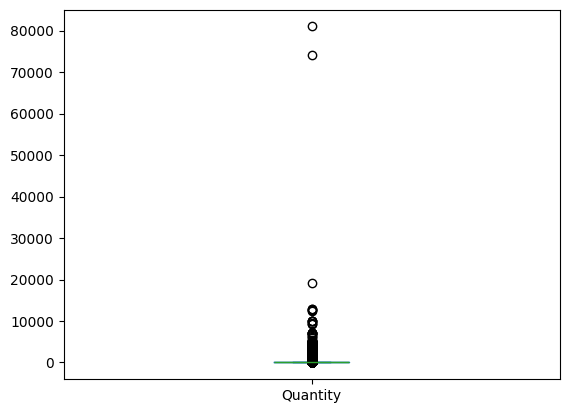

In [143]:
# Visualizing 'Quantity' distribution with box plot
df['Quantity'].plot(kind='box')


In [144]:
# Removing extreme outliers above 20,000 units
df = df[df['Quantity'] < 20000]


# D. Feature Engineering

In [145]:
# Reference date for Recency
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Create TotalPrice for Monetary
df["TotalPrice"] = df["Quantity"] * df["Price"]

# Aggregate RFM
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,  # Recency
    "Invoice": "nunique",                                      # Frequency
    "TotalPrice": "sum"                                        # Monetary
}).rename(columns={
    "InvoiceDate": "R",
    "Invoice": "F",
    "TotalPrice": "M"
})

# Min–Max Scaling
scaler = MinMaxScaler()
rfm_scaled = pd.DataFrame(
    scaler.fit_transform(rfm),
    columns=["R_scaled", "F_scaled", "M_scaled"],
    index=rfm.index
)

# Invert Recency (lower days = better)
rfm_scaled["R_scaled"] = 1 - rfm_scaled["R_scaled"]

# Final RFM table
rfm_final = pd.concat([rfm, rfm_scaled], axis=1)

rfm_final.head()


,R,F,M,R_scaled,F_scaled,M_scaled
CustomerID,,,,,,
123460,529,11,18971.0,0.284553,0.025189,0.000378
123470,2,8,484377.0,0.998645,0.017632,0.009656
123480,75,5,169450.0,0.899729,0.010076,0.003378
123490,19,4,359799.0,0.975610,0.007557,0.007172
123500,310,1,20768.0,0.581301,0.000000,0.000414


In [146]:
# Calculate Weighted RFM Score (Apply weights 0.3, 0.3, 0.4)

rfm_final['RFM_Score'] = rfm_final['R_scaled'] * 0.3 + rfm_final['F_scaled'] * 0.3 + rfm_final['M_scaled'] * 0.4

rfm_final.sort_values(by='RFM_Score', ascending=False).head(10)

,R,F,M,R_scaled,F_scaled,M_scaled,RFM_Score
CustomerID,,,,,,,
149110,1,398,26808336.0,1.000000,1.000000,0.534415,0.813766
146460,2,152,50163852.0,0.998645,0.380353,1.000000,0.813699
181020,1,145,46750946.0,1.000000,0.362720,0.931965,0.781602
141560,10,156,29696915.0,0.987805,0.390428,0.591998,0.650269
127480,1,337,4567166.0,1.000000,0.846348,0.091045,0.590322
136940,4,143,19101262.0,0.995935,0.357683,0.380777,0.558396
153110,1,208,10896315.0,1.000000,0.521411,0.217214,0.543309
130890,3,203,10868948.0,0.997290,0.508816,0.216669,0.538499
178410,2,211,6496361.0,0.998645,0.528967,0.129503,0.510085


In [147]:
# Label VIP vs Non-VIP Customers
# VIP customers are defined as the top 20% by RFM score.

threshold = rfm_final["RFM_Score"].quantile(0.8)

rfm_final["Label"] = rfm_final["RFM_Score"].apply(
    lambda x: "VIP" if x > threshold else "Non-VIP"
)
print(rfm_final[["RFM_Score", "Label"]])

            RFM_Score    Label
CustomerID                    
123460       0.093074  Non-VIP
123470       0.308746      VIP
123480       0.274293  Non-VIP
123490       0.297819  Non-VIP
123500       0.174556  Non-VIP
...               ...      ...
182830       0.316673      VIP
182840       0.125111  Non-VIP
182850       0.031988  Non-VIP
182860       0.108224  Non-VIP
182870       0.290365  Non-VIP

[5881 rows x 2 columns]


In [148]:
# Count of VIP vs Non-VIP customers
rfm_final['Label'].value_counts()

Label
Non-VIP    4705
VIP        1176
Name: count, dtype: int64

# E. Model Training & Evaluation (KNN)

## 1. Model Training

In [149]:
rfm_final

,R,F,M,R_scaled,F_scaled,M_scaled,RFM_Score,Label
CustomerID,,,,,,,,
123460,529,11,18971.0,0.284553,0.025189,0.000378,0.093074,Non-VIP
123470,2,8,484377.0,0.998645,0.017632,0.009656,0.308746,VIP
123480,75,5,169450.0,0.899729,0.010076,0.003378,0.274293,Non-VIP
123490,19,4,359799.0,0.975610,0.007557,0.007172,0.297819,Non-VIP
123500,310,1,20768.0,0.581301,0.000000,0.000414,0.174556,Non-VIP
...,...,...,...,...,...,...,...,...
182830,4,22,253818.0,0.995935,0.052897,0.005060,0.316673,VIP
182840,432,1,39400.0,0.415989,0.000000,0.000785,0.125111,Non-VIP
182850,661,1,35140.0,0.105691,0.000000,0.000701,0.031988,Non-VIP


In [155]:
rfm_final = rfm_final.reset_index()

In [156]:
# Prepare data for KNN clustering

df_knn = rfm_final[['R_scaled','F_scaled','M_scaled']]

scaler = MinMaxScaler()
X = scaler.fit_transform(df_knn[['R_scaled','F_scaled','M_scaled']])
X_new = scaler.transform(df_knn)
X_new

array([[2.84552846e-01, 2.51889169e-02, 3.78180687e-04],
       [9.98644986e-01, 1.76322418e-02, 9.65589724e-03],
       [8.99728997e-01, 1.00755668e-02, 3.37793039e-03],
       ...,
       [1.05691057e-01, 0.00000000e+00, 7.00504419e-04],
       [3.55013550e-01, 2.51889169e-03, 2.41179645e-03],
       [9.43089431e-01, 1.51133501e-02, 7.26110507e-03]], shape=(5881, 3))

In [158]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X, rfm_final["Label"])

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


## 2. Predict New User

In [173]:
data = {
    "CustomerID": ["C001","C002","C003","C004","C005","C006","C007","C008","C009","C010"],
    "R_scaled":     [0.92, 0.83, 0.40, 0.30, 0.45, 0.50, 0.25, 0.40, 0.35, 0.10],
    "F_scaled":   [0.20, 0.20, 0.60, 0.80, 0.05, 0.50, 0.20, 0.30, 0.25, 0.40],
    "M_scaled":    [0.15, 0.30, 0.30, 0.80, 0.10, 0.55, 0.35, 0.40, 0.25, 0.45]
}

df_new = pd.DataFrame(data)

print(df_new)


  CustomerID  R_scaled  F_scaled  M_scaled
0       C001      0.92      0.20      0.15
1       C002      0.83      0.20      0.30
2       C003      0.40      0.60      0.30
3       C004      0.30      0.80      0.80
4       C005      0.45      0.05      0.10
5       C006      0.50      0.50      0.55
6       C007      0.25      0.20      0.35
7       C008      0.40      0.30      0.40
8       C009      0.35      0.25      0.25
9       C010      0.10      0.40      0.45


In [174]:
X_new = df_new[["R_scaled", "F_scaled", "M_scaled"]]
df_new["Predicted_Label"] = knn.predict(X_new)
df_new

c:\Users\Hiep\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


,CustomerID,R_scaled,F_scaled,M_scaled,Predicted_Label
0,C001,0.92,0.20,0.15,VIP
1,C002,0.83,0.20,0.30,VIP
2,C003,0.40,0.60,0.30,Non-VIP
3,C004,0.30,0.80,0.80,VIP
4,C005,0.45,0.05,0.10,Non-VIP
5,C006,0.50,0.50,0.55,VIP
6,C007,0.25,0.20,0.35,Non-VIP
7,C008,0.40,0.30,0.40,Non-VIP
8,C009,0.35,0.25,0.25,Non-VIP
9,C010,0.10,0.40,0.45,Non-VIP


# F. Save Clear Data Into Database To Visiualization

In [177]:
import pyodbc

# --- Connect ---
conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost\SQLEXPRESS;"
    "DATABASE=vti_data;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)
cursor = conn.cursor()

# --- Map pandas dtype -> SQL Server type ---
dtype_map = lambda dt: "INT" if pd.api.types.is_integer_dtype(dt) else \
                       "FLOAT" if pd.api.types.is_float_dtype(dt) else \
                       "BIT" if pd.api.types.is_bool_dtype(dt) else \
                       "DATETIME" if pd.api.types.is_datetime64_any_dtype(dt) else \
                       "VARCHAR(255)"

table_name = "online_retail_cleaned"

# --- Drop + Create table ---
cursor.execute(f"IF OBJECT_ID('dbo.{table_name}', 'U') IS NOT NULL DROP TABLE dbo.{table_name}")
cols = ", ".join([f"[{c}] {dtype_map(df[c].dtype)}" for c in df.columns]) #
cursor.execute(f"CREATE TABLE dbo.{table_name} ({cols})")

# --- Insert rows ---
cursor.fast_executemany = True
cursor.executemany(f"INSERT INTO dbo.{table_name} VALUES ({','.join(['?']*len(df.columns))})", df.values.tolist()) #
conn.commit()

<>:6: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
<>:6: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
C:\Users\Hiep\AppData\Local\Temp\ipykernel_12184\3042453848.py:6: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
  "SERVER=localhost\SQLEXPRESS;"


In [176]:
import pyodbc

# --- Connect ---
conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost\SQLEXPRESS;"
    "DATABASE=vti_data;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)
cursor = conn.cursor()

# --- Map pandas dtype -> SQL Server type ---
dtype_map = lambda dt: "INT" if pd.api.types.is_integer_dtype(dt) else \
                       "FLOAT" if pd.api.types.is_float_dtype(dt) else \
                       "BIT" if pd.api.types.is_bool_dtype(dt) else \
                       "DATETIME" if pd.api.types.is_datetime64_any_dtype(dt) else \
                       "VARCHAR(255)"

table_name = "online_retail_rfm_score" #

# --- Drop + Create table ---
cursor.execute(f"IF OBJECT_ID('dbo.{table_name}', 'U') IS NOT NULL DROP TABLE dbo.{table_name}")
cols = ", ".join([f"[{c}] {dtype_map(rfm_final[c].dtype)}" for c in rfm_final.columns]) #
cursor.execute(f"CREATE TABLE dbo.{table_name} ({cols})")

# --- Insert rows ---
cursor.fast_executemany = True
cursor.executemany(f"INSERT INTO dbo.{table_name} VALUES ({','.join(['?']*len(rfm_final.columns))})", rfm_final.values.tolist()) #
conn.commit()

<>:6: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
<>:6: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
C:\Users\Hiep\AppData\Local\Temp\ipykernel_12184\952853477.py:6: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
  "SERVER=localhost\SQLEXPRESS;"


In [178]:
import pyodbc

# --- Connect ---
conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=localhost\SQLEXPRESS;"
    "DATABASE=vti_data;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)
cursor = conn.cursor()

# --- Map pandas dtype -> SQL Server type ---
dtype_map = lambda dt: "INT" if pd.api.types.is_integer_dtype(dt) else \
                       "FLOAT" if pd.api.types.is_float_dtype(dt) else \
                       "BIT" if pd.api.types.is_bool_dtype(dt) else \
                       "DATETIME" if pd.api.types.is_datetime64_any_dtype(dt) else \
                       "VARCHAR(255)"

table_name = "online_retail_new" #

# --- Drop + Create table ---
cursor.execute(f"IF OBJECT_ID('dbo.{table_name}', 'U') IS NOT NULL DROP TABLE dbo.{table_name}")
cols = ", ".join([f"[{c}] {dtype_map(df_new[c].dtype)}" for c in df_new.columns]) #
cursor.execute(f"CREATE TABLE dbo.{table_name} ({cols})")

# --- Insert rows ---
cursor.fast_executemany = True
cursor.executemany(f"INSERT INTO dbo.{table_name} VALUES ({','.join(['?']*len(df_new.columns))})", df_new.values.tolist()) #
conn.commit()

<>:6: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
<>:6: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
C:\Users\Hiep\AppData\Local\Temp\ipykernel_12184\3374178094.py:6: SyntaxWarning: "\S" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\S"? A raw string is also an option.
  "SERVER=localhost\SQLEXPRESS;"
